In [ ]:
!pip install igraph
!pip install cairo
!apt-get install python-cairo
!apt-get install libcairo2-dev
!pip install pycairo
from igraph import *
import json
import random
import cairo
import networkx as nx
import numpy as np
from numpy import linalg 
import itertools
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay  # needed for triangulation
import os
import pandas as pd
from copy import deepcopy
from google.colab import drive
drive.mount('/content/drive')
LIBRARY_PATH = '/content/drive/MyDrive/232EProject1'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement cairo (from versions: none)
ERROR: No matching distribution found for cairo
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  python-cairo
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 56.4 kB of archives.
After this operation, 257 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python-cairo amd64 1.16.2-1 [56.4 kB]
Fetched 56.4 kB in 0s (143 kB/s)
Selecting previously 

In [ ]:
!Pirandom.seed(2022)
np.random.seed(2022)

/bin/bash: -c: line 0: syntax error near unexpected token `2022'
/bin/bash: -c: line 0: `Pirandom.seed(2022)'


 # Question 9

In [ ]:
with open(LIBRARY_PATH + '/los_angeles_censustracts.json') as f:
    census_tracts = json.loads(f.readline())

In [ ]:
display_names = dict()
coordinates = dict()


for area in census_tracts['features']:
    id = int(area['properties']['MOVEMENT_ID'])
    display_name = area['properties']['DISPLAY_NAME']
    display_names[id] = display_name
    a = area['geometry']['coordinates'][0]
    coordinates[id] = np.array(a if type(a[0][0]) == float else a[0]).mean(axis=0)


In [ ]:
coordinates.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

In [ ]:
g = Graph(directed=False)
g.add_vertices(len(display_names))
g.vs['display_name'] = list(display_names.values())  # index = id - 1
g.vs['coordinates'] = list(coordinates.values())

In [ ]:
month_filter = {12}  # for monthly aggregate data of 4th quarter, we can filter data based off of only December

edges = []
weights = []

with open(LIBRARY_PATH + '/los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv') as f:
    f.readline()  # skip the first line
    
    while True:
        line = f.readline()
        if line == '':
            break  # end of file
        
        vals = line.strip().split(',')
        
        # read edge info
        src, dest, month, dist = int(vals[0]), int(vals[1]), int(vals[2]), float(vals[3])

        # if data is not relevant, skip it
        if month not in month_filter:
            continue
            
        edges.append((src - 1, dest - 1))
        weights.append(dist)  


In [ ]:
g.add_edges(edges)
g.es['weight'] = weights
del edges, weights

In [ ]:
print(len(g.vs), len(g.es))

2716 1692450


In [ ]:
# keep only the giant connected component
components = g.components()
gcc = max(components, key=len)
vs_to_delete = [i for i in range(len(g.vs)) if i not in gcc]
g.delete_vertices(vs_to_delete)

# remove duplicate edges
g = g.simplify(combine_edges=dict(weight='mean'))  # combine duplicate edges

In [ ]:
print(len(g.vs), len(g.es))

2649 1003858


In [ ]:
copy_g = deepcopy(g)

# Question 10

In [ ]:
mst = g.spanning_tree(weights=g.es['weight'])

In [ ]:
edf = mst.get_edge_dataframe()
edf.head()

,source,target,weight
edge ID,,,
0,0,2,129.765
1,0,13,118.335
2,1,2,90.235
3,1,3,126.475
4,1,9,125.675


In [ ]:
for e in mst.es()[:10]:
    x, x1,y,y1 = mst.vs(e.tuple[0])[0]['display_name'],mst.vs(e.tuple[0])[0]['coordinates'] , mst.vs(e.tuple[1])[0]['display_name'],mst.vs(e.tuple[1])[0]['coordinates']
    print(x,x1, 
          y,y1)

Census Tract 480302 [-118.12053321   34.10309557] Census Tract 480304 [-118.13138209   34.09626386]
Census Tract 480302 [-118.12053321   34.10309557] Census Tract 481002 [-118.11656383   34.09585388]
Census Tract 480303 [-118.13785063   34.09645121] Census Tract 480304 [-118.13138209   34.09626386]
Census Tract 480303 [-118.13785063   34.09645121] Census Tract 480400 [-118.13224544   34.10349303]
Census Tract 480303 [-118.13785063   34.09645121] Census Tract 480901 [-118.14184446   34.08538654]
Census Tract 480304 [-118.13138209   34.09626386] Census Tract 481001 [-118.12911933   34.08759475]
Census Tract 480400 [-118.13224544   34.10349303] Census Tract 480500 [-118.14492317   34.0986815 ]
Census Tract 480500 [-118.14492317   34.0986815 ] Census Tract 480804 [-118.15023891   34.09595766]
Census Tract 480704 [-118.1528085   34.098628 ] Census Tract 480804 [-118.15023891   34.09595766]
Census Tract 480704 [-118.1528085   34.098628 ] Census Tract 480704 [-118.1557638   34.0986163]


In [ ]:
visual_style = {}
visual_style["vertex_size"] = 3
plot(mst,**visual_style)
out = plot(mst,**visual_style)
out.save('Q10.png')

# Question 11

In [ ]:
def is_triangle(sides):
    l, w, h = sides[0], sides[1], sides[2]
    if l+w>h and l+h>w and h+w>l: 
      return True
    else:
      return False


def sample_triangles(g, n_samples):
    count = 0
    result = list()
    while len(result) < n_samples:
       try:
          points = np.random.randint(1,high=len(g.vs),size=3)
          e1, e2, e3 = g.get_eid(points[0],points[1]), g.get_eid(points[1],points[2]), g.get_eid(points[2],points[0])
          weights = [g.es['weight'][e1],g.es['weight'][e2],g.es['weight'][e3]]
          result.append(weights)
       except:
          continue

    #result will have tuple of the the vertices of a triangle 
    return result 

In [ ]:
result = sample_triangles(g,1000)

In [ ]:
counter = 0 
for weight in result:
    if is_triangle(weight):
        counter+=1
print(counter/len(result))

0.912


# Question 12

In [ ]:
mst_cost = sum(mst.es['weight'])
df = pd.read_csv(LIBRARY_PATH + '/los_angeles-censustracts-2019-4-All-MonthlyAggregate.csv')
df = df[df['month']==12][['sourceid','dstid','mean_travel_time']]
df = df.values
for i in range(0,len(df)):
    if(df[i][0]>df[i][1]):
        t = df[i][0]
        df[i][0] = df[i][1]
        df[i][1] = t
newdf = pd.DataFrame(df)
arr1 = newdf.groupby([0,1]).mean().reset_index()
arr1 = arr1.rename(columns={0: "source", 1: "sink", 2: "weight"})

g_ = nx.from_pandas_edgelist(arr1, 'source','sink', ['weight'])
gcc_ = g_.subgraph(max(nx.connected_components(g_), key=len))
mst = nx.minimum_spanning_tree(gcc_)
mg = nx.MultiGraph()
for i in mst.edges:
    w = mst.edges[i[0],i[1]]['weight']
    mg.add_edge(i[0],i[1],weight=w)
    mg.add_edge(i[0],i[1],weight=w)


vertices, count = [], 0
for i in mg.nodes:
    vertices.append(i)
    count += 1
    if count>60: 
        break



In [ ]:
costs, current_paths = [], []
for vertex in vertices:
    tour = [u for u,v in nx.eulerian_circuit(mg,source=vertex)]
    path , visited_nodes = [], set()
    for i in tour:
        if i not in visited_nodes: 
            path.append(i) 
            visited_nodes.add(i) 
    path.append(path[0])
    current_paths.append(path)
    tsp_cost = 0
    for i in range(len(path)-1):
        s,t = path[i], path[i+1]
        w = 0
        if mst.has_edge(s,t): 
            w = mst.edges[s,t]['weight']
        else: 
            w = nx.dijkstra_path_length(gcc,s,t)
        tsp_cost += w
    costs.append(tsp_cost)

min_tsp_cost = min(costs)
trajectory = current_paths[np.argmin(costs)]

In [ ]:
print('MST cost:',round(mst_cost))
print('TSP cost:',round(min_tsp_cost))
print('Upper Bound:',round(min_tsp_cost/mst_cost,2))

MST cost: 269085
TSP cost: 421489
Upper Bound: 1.57


# Question 13

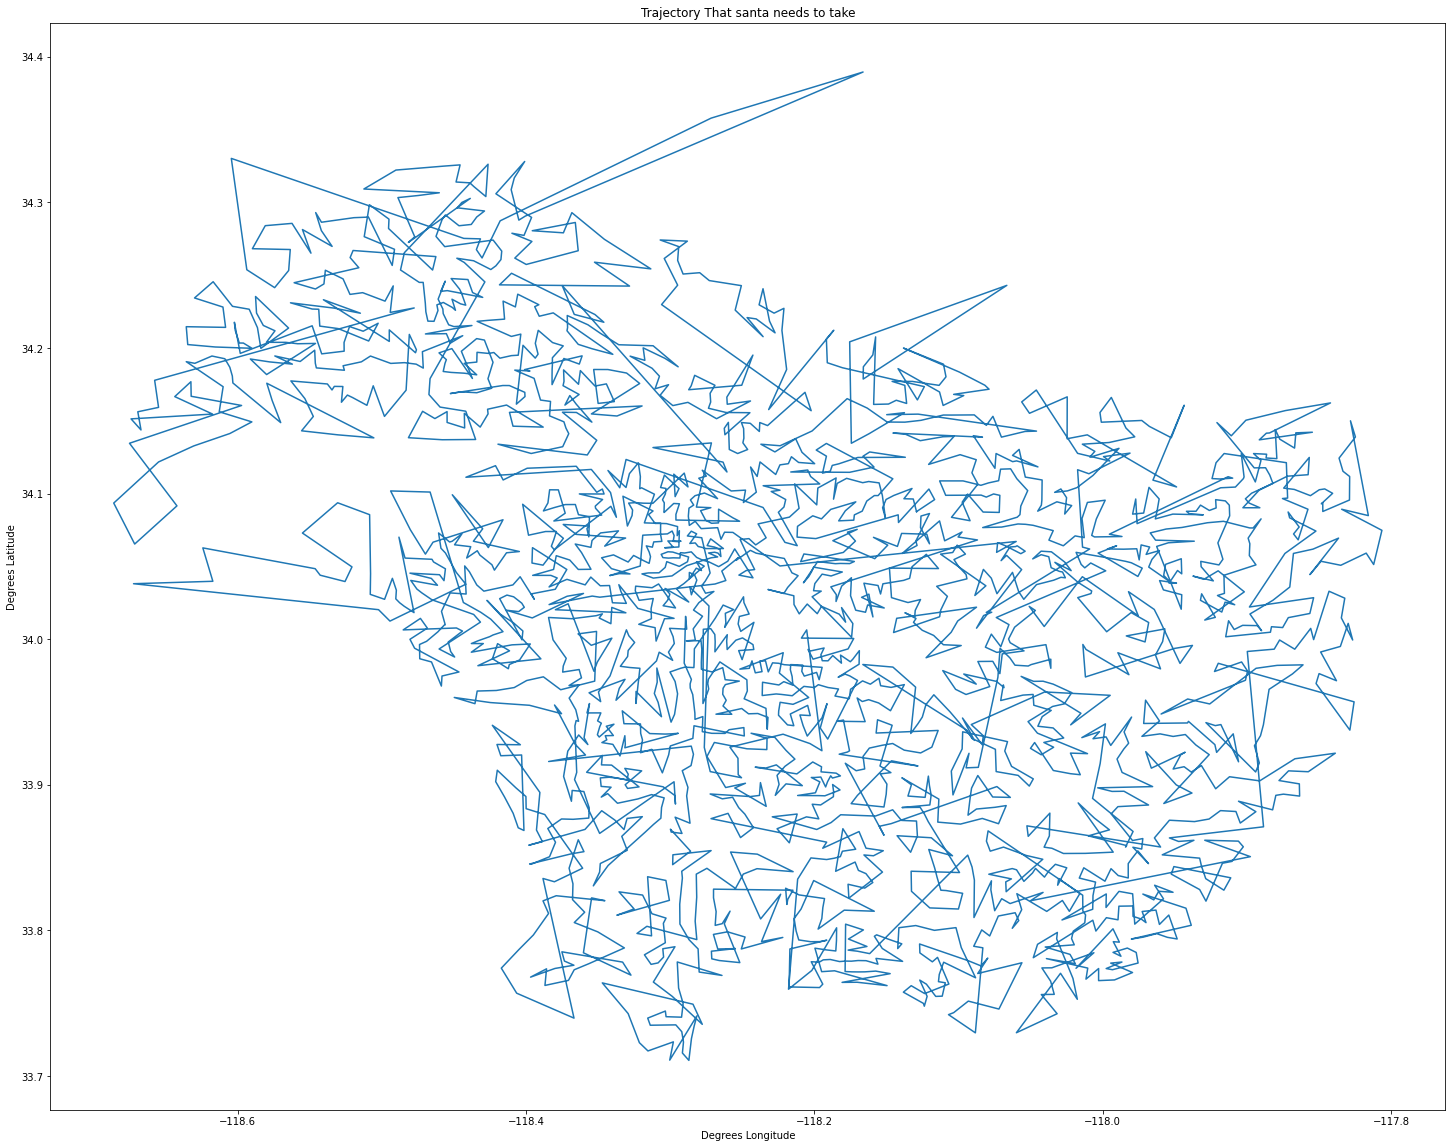

In [ ]:
latitude = []
longitude = []


for i in trajectory:
    latitude.append(coordinates[int(i)][1])
    longitude.append(coordinates[int(i)][0])

plt.figure(figsize=(25,20))

plt.plot(longitude, latitude,'-')
plt.title('Trajectory That santa needs to take')
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.savefig('Q13.png',dpi=500,bbox_inches='tight')
plt.show()
plt.savefig('Q14a.png',dpi=500,bbox_inches='tight')


# Question 14 

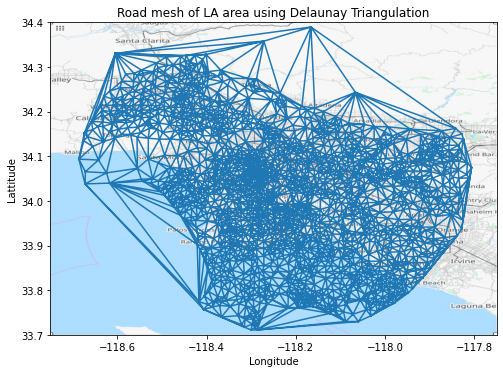

In [ ]:
tri = Delaunay(g.vs['coordinates'])
ruh_m = plt.imread(LIBRARY_PATH + '/LAmap.jpeg')
BBox = ((-118.75,   -117.75,      
         33.7, 34.4))
all_coordinates = np.array(g.vs['coordinates'])
fig, ax = plt.subplots(figsize = (8,7))
plt.triplot(all_coordinates[:, 0], all_coordinates[:, 1], tri.simplices.copy())
ax.set_title('Road mesh of LA area using Delaunay Triangulation')
plt.xlabel('Longitude')
plt.ylabel('Lattitude')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')
plt.savefig('Q14a.png',dpi=500,bbox_inches='tight')
plt.show()

In [ ]:
edges_to_induce = []

for i in range(tri.simplices.shape[0]):
    for col1, col2 in ((0, 1), (1, 2), (0, 2)):
        edges_to_induce += list(g.es.select(_between=([tri.simplices[i, col1]], [tri.simplices[i, col2]])))

In [ ]:
tri_g = g.subgraph_edges(edges_to_induce)

In [ ]:
visual_style = {}
visual_style["vertex_size"] = 3
out = plot(tri_g,**visual_style)
out.save('Q14b.png')

# Question 16

In [ ]:
from numpy.linalg import norm

#  Checker code for max flow
coordinates = np.array(tri_g.vs['coordinates'])
source_coordinates = [-118.5670548, 34.0458901]  # malibu
dest_coordinates = [-118.1819374, 33.759958]  # long beach

# source_idx = None
# dest_idx = None

# for i, coord in enumerate(coordinates):
#     if(coord[0] == source_coordinates[0] and  coord[1] == source_coordinates[1]):
#         source_idx = i
#     if(coord[0] == dest_coordinates[0] and  coord[1] == dest_coordinates[1]):
#         dest_idx = i

# Finding coordinates which are closest to the source and destination coordinates

source_min_dist = dest_min_dist = np.inf
source_idx = dest_idx = -1

for idx, v in enumerate(tri_g.vs):
    c = v['coordinates']
    
    source_dist = norm(c - source_coordinates)
    dest_dist = norm(c - dest_coordinates)
    
    if source_min_dist > source_dist:
        source_min_dist = source_dist
        source_idx = idx
    if dest_min_dist > dest_dist:
        dest_min_dist = dest_dist
        dest_idx = idx

In [ ]:
coordinates = np.array(tri_g.vs['coordinates'])
edge_ends = np.array([[edge.source, edge.target] for edge in tri_g.es])
sources, targets = edge_ends[:, 0], edge_ends[:, 1]
distances = norm(coordinates[sources, :] - coordinates[targets, :], axis = 1) * 69
speeds =  distances / np.array(tri_g.es['weight']) * 3600
car_length = 0.003  # (miles)
safety_distances = speeds * (2/3600)  # in miles, derived from 2 sec distance
cars_per_mile = 1 / (car_length + safety_distances)
n_lanes = 2
cars_per_hour = cars_per_mile * speeds * n_lanes

In [ ]:
tri_g.es['capacity'] = cars_per_hour

In [ ]:
print('Number of independent roads:', int(tri_g.maxflow_value(source_idx, dest_idx))) #max flow of graph (inbuilt is okay )
print('Number of cars per hour:', round(tri_g.maxflow_value(source_idx, dest_idx, capacity='capacity')))

Number of independent roads: 4
Number of cars per hour: 11074


In [ ]:
malibu_node = coordinates[source_idx]
long_beach_node = coordinates[dest_idx]

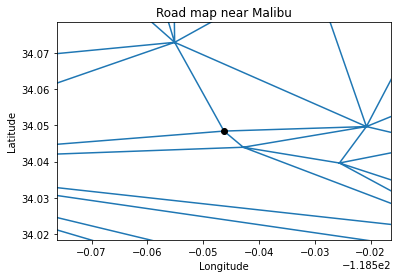

In [ ]:
plt.triplot(all_coordinates[:, 0], all_coordinates[:, 1], tri.simplices)
plt.ylim(malibu_node[1]-0.03,malibu_node[1]+0.03)
plt.xlim(malibu_node[0]-0.03,malibu_node[0]+0.03)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road map near Malibu')
plt.plot(malibu_node[0], malibu_node[1],'o',color='black')
plt.savefig('Q16a.png',dpi=500,bbox_inches='tight')
plt.show()

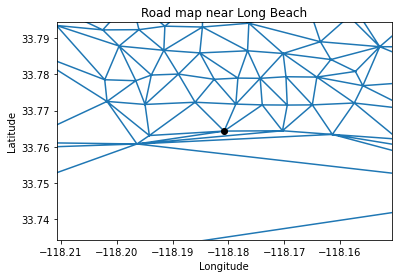

In [ ]:
plt.triplot(all_coordinates[:, 0], all_coordinates[:, 1], tri.simplices)
plt.ylim(long_beach_node[1]-0.03,long_beach_node[1]+0.03)
plt.xlim(long_beach_node[0]-0.03,long_beach_node[0]+0.03)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road map near Long Beach')
plt.plot(long_beach_node[0], long_beach_node[1],'o',color='black')
plt.savefig('Q16b.png',dpi=500,bbox_inches='tight')
plt.show()

# Question 17

In [ ]:
trim_thresh = 800
edges_to_induce = tri_g.es.select(weight_le=trim_thresh)
tri_g_trimmed = tri_g.subgraph_edges(edges_to_induce)


# plot the roads
plt.figure(figsize=(15,15), dpi=200)
for e in tri_g.es:
    v1 = tri_g.vs[e.source]['coordinates']
    v2 = tri_g.vs[e.target]['coordinates']
    data = np.vstack([v1, v2])
    x = data[:, 0]
    y = data[:, 1]
    plt.plot(x, y, '#8ab4f7' if e['weight'] < trim_thresh else '#fc9c3c')
    
# mark the source and destination
# source = tri_g.vs.select(display_name=source_address)[0].index
# target = tri_g.vs.select(display_name=dest_address)[0].index
# v1 = tri_g.vs[source_idx]['coordinates']
# v2 = tri_g.vs[dest_idx]['coordinates']
# data = np.vstack([v1, v2])
# x = data[:, 0]
# y = data[:, 1]
# plt.plot(x, y, 'bo')


plt.axis('equal')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

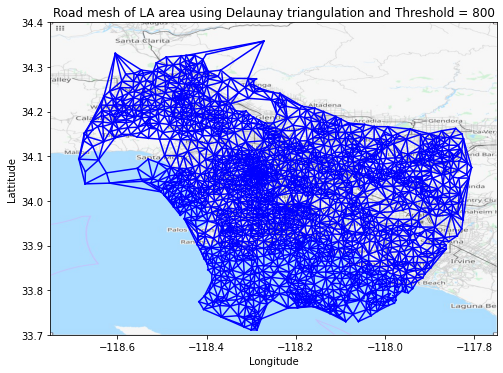

In [ ]:
ruh_m = plt.imread(LIBRARY_PATH + '/LAmap.jpeg')
BBox = ((-118.75,   -117.75,      
         33.7, 34.4))
fig, ax = plt.subplots(figsize = (8,7))
for e in tri_g_trimmed.es:
    v1 = tri_g_trimmed.vs[e.source]['coordinates']
    v2 = tri_g_trimmed.vs[e.target]['coordinates']
    data = np.vstack([v1, v2])
    x = data[:, 0]
    y = data[:, 1]
    plt.plot(x, y,color='blue')
ax.set_title('Road mesh of LA area using Delaunay triangulation and Threshold = 800')
plt.xlabel('Longitude')
plt.ylabel('Lattitude')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')
plt.savefig('Q17.png',dpi=500,bbox_inches='tight')
plt.show()

In [ ]:
visual_style = {}
visual_style["vertex_size"] = 3
out = plot(tri_g_trimmed,**visual_style)
out.save('Q17b.png')

# Question 18

In [ ]:
print('Number of independent roads:', int(tri_g_trimmed.maxflow_value(source_idx, dest_idx))) #max flow of graph (inbuilt is okay )
print('Number of cars per hour:', round(tri_g_trimmed.maxflow_value(source_idx, dest_idx, capacity='capacity')))

Number of independent roads: 4
Number of cars per hour: 11074


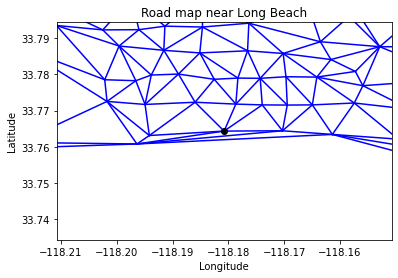

In [ ]:

for e in tri_g_trimmed.es:
    v1 = tri_g_trimmed.vs[e.source]['coordinates']
    v2 = tri_g_trimmed.vs[e.target]['coordinates']
    data = np.vstack([v1, v2])
    x = data[:, 0]
    y = data[:, 1]
    plt.plot(x, y,color='blue')
plt.ylim(long_beach_node[1]-0.03,long_beach_node[1]+0.03)
plt.xlim(long_beach_node[0]-0.03,long_beach_node[0]+0.03)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road map near Long Beach')
plt.plot(long_beach_node[0], long_beach_node[1],'o',color='black')
plt.savefig('Q18a.png',dpi=500,bbox_inches='tight')
plt.show()

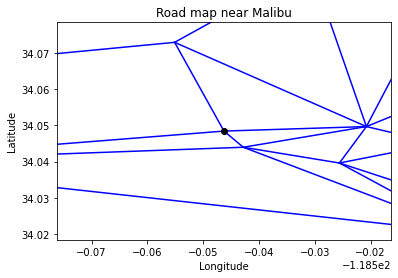

In [ ]:
for e in tri_g_trimmed.es:
    v1 = tri_g_trimmed.vs[e.source]['coordinates']
    v2 = tri_g_trimmed.vs[e.target]['coordinates']
    data = np.vstack([v1, v2])
    x = data[:, 0]
    y = data[:, 1]
    plt.plot(x, y,color='blue')
plt.ylim(malibu_node[1]-0.03,malibu_node[1]+0.03)
plt.xlim(malibu_node[0]-0.03,malibu_node[0]+0.03)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Road map near Malibu')
plt.plot(malibu_node[0], malibu_node[1],'o',color='black')
plt.savefig('Q18b.png',dpi=500,bbox_inches='tight')
plt.show()